In [1]:
import networkx as nx
import numpy as np
from scipy.special import binom
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm
import multiprocessing
from time import time
import pickle
from pprint import pprint

from methods import *

np.random.seed(1234)

## Code

In [2]:
# Adjacency matrix (undirected graph with self-loops)
N = 30
upper_triangular = np.triu(np.random.randint(0, 2, size=(N, N)), 1)
A = mirrorUpperTri(upper_triangular)
np.fill_diagonal(A, np.random.randint(0, 2, size=N))

upper_triangular = np.triu(np.random.randint(0, 2, size=(N, N)), 1)
A_obs = upper_triangular + upper_triangular.T
np.fill_diagonal(A_obs, np.random.randint(0, 2, size=N))

Number of nodes: 62


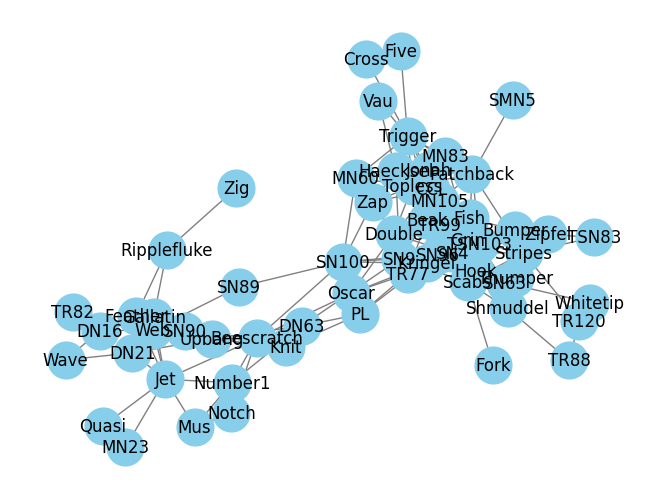

In [36]:
# Get the Karate Club network
G = nx.karate_club_graph().to_undirected()
G = nx.florentine_families_graph().to_undirected()
G = nx.read_gml("dolphins.gml").to_undirected()

A = nx.adjacency_matrix(G).todense()
A = (A > 0).astype(int)
N = A.shape[0]

print("Number of nodes:", N)

nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, font_size=12, font_color='black', edge_color='gray')

### Trials

In [37]:
A_obs = corruptAdjacencyMatrix(A, p=0.2, mode='both')
A_obs

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

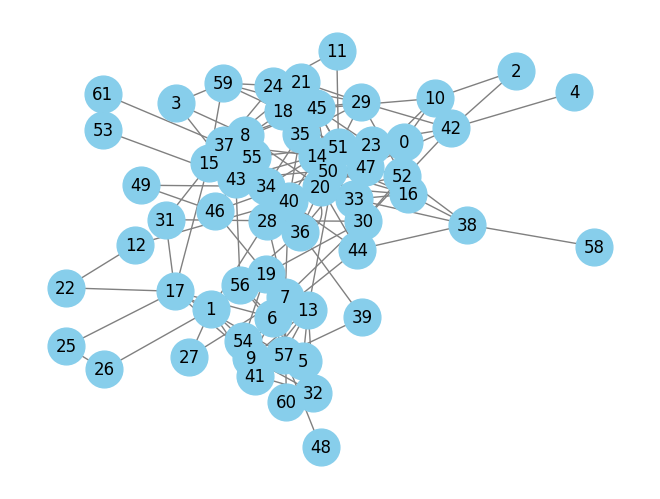

In [38]:
G_obs = nx.from_numpy_array(A_obs)
nx.draw(G_obs, with_labels=True, node_color='skyblue', node_size=700, font_size=12, font_color='black', edge_color='gray')

In [39]:
# Groups data structure: list of lists
groups = [[] for _ in range(N)]

# Uniformly random initialization
for i in range(N): 
    g = np.random.randint(0, N)
    groups[g].append(i)

# Transient time (to test convergence)
max_iter = 1000
H = hamiltonian(A_obs, groups, offset=0)
transient = np.zeros(max_iter+1)
transient[0] = H
for k in range(max_iter):
    print("Progress: ", k, "/", max_iter, end="\r")
    groups, H = singleStep(groups, H, A_obs, offset=0)

    transient[k+1] = H

In [40]:
# NMI at equilibrium
steps = 10000
belongs_to = arrayGroups(groups)
nmi = np.zeros(steps)
for k in range(steps):
    print("Progress: ", k, "/", steps, end="\r")
    groups, H = singleStep(groups, H, A_obs, offset=0)
    nmi[k] = normalized_mutual_info_score(belongs_to, arrayGroups(groups))

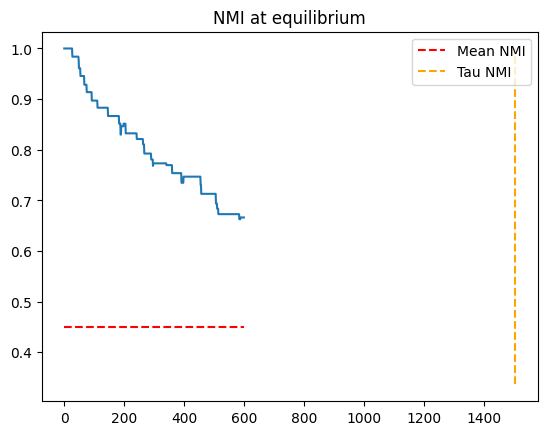

In [41]:
plt.title("NMI at equilibrium")
cut_plot = 600
plt.plot(nmi[:cut_plot])
plt.hlines(np.mean(nmi), 0, cut_plot, colors='red', linestyles='dashed', label='Mean NMI')
tau = np.where(nmi < np.mean(nmi))[0][0]
plt.vlines(tau, np.min(nmi), 1, colors='orange', linestyles='dashed', label='Tau NMI')
plt.legend()

IndexError: index 0 is out of bounds for axis 0 with size 0

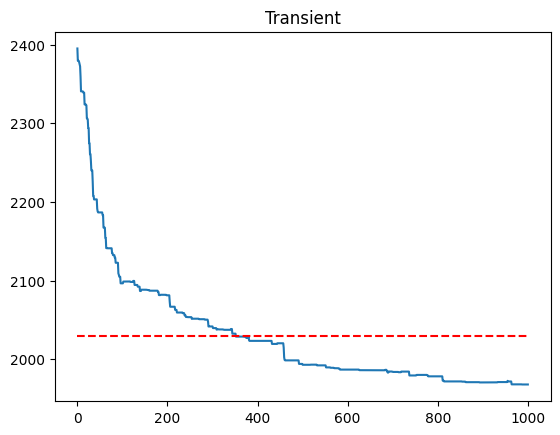

In [42]:
plt.title("Transient")
iters = len(transient)
t = np.arange(iters)

plt.plot(t, transient)
plt.hlines(np.mean(transient), 0, iters, color='red', linestyle='--')

num_bins = len(transient) // tau
mean_transient = transient[:num_bins*tau].reshape(num_bins, tau).mean(axis=1)
binned_time = np.arange(num_bins*tau).reshape(num_bins, tau).mean(axis=1)
tau_transient = binned_time[np.where(mean_transient < np.mean(transient))[0][0]] + tau/2

plt.plot(binned_time, mean_transient, "o--", ms=4)
plt.vlines(tau_transient, np.min(transient), np.max(transient), colors='orange', linestyles='dashed')

In [127]:
getTimeScales(A_obs, max_iter=1e3, trials=5)

100%|██████████| 5/5 [01:11<00:00, 14.36s/it]


array([342.5       ,  85.        , 143.65850294])

In [25]:
# # Equilibrium (not in parallel)
# delay = 50 # for uncorrelate the samples
# n_samples = 20
# partitions_set = []

# for k in tqdm(range(n_samples)):
#     for _ in range(delay):
#         groups, H = singleStep(groups, H, A)
#     partitions_set.append(groups)

In [26]:
# Equilibrium: get the set of partitions
partitions_set, hamiltionian_list = parallelPartitionsSet(A, groups, n_samples=20, delay=20, n_cores=-1, return_H=True)

In [37]:
partitions_set, hamiltionian_list = generatePartitionsSet(A_obs, n_samples=1e3, delay=20, transient=500, offset=2000, n_cores=-1, return_H=True)

In [38]:
getNetworkReliability(A, A_obs, partitions_set, hamiltionian_list)

np.longdouble('7.779299820270306381e-126')

In [39]:
computeLinkReliabilityMatrix(A_obs, partitions_set, hamiltionian_list)

array([[0.03222397, 0.13053007, 0.09908438, ..., 0.07133829, 0.10503521,
        0.06581782],
       [0.13053007, 0.10166573, 0.12085623, ..., 0.10911278, 0.21542246,
        0.23400009],
       [0.09908438, 0.12085623, 0.03984883, ..., 0.04572664, 0.07054114,
        0.21639354],
       ...,
       [0.07133829, 0.10911278, 0.04572664, ..., 0.0398618 , 0.06560599,
        0.21439052],
       [0.10503521, 0.21542246, 0.07054114, ..., 0.06560599, 0.00875174,
        0.09854555],
       [0.06581782, 0.23400009, 0.21639354, ..., 0.21439052, 0.09854555,
        0.02044902]], dtype=float128)

In [32]:
computeLinkReliabilityMatrix(A_obs, partitions_set, 2000, hamiltionian_list)

array([[0.09488653, 0.42700609, 0.17950953, 0.23912209, 0.20760307,
        0.15091446, 0.17704069, 0.16506524, 0.17420988, 0.13559635,
        0.21527284, 0.15110993, 0.29905406, 0.1813639 , 0.16089428],
       [0.42700609, 0.3023363 , 0.28435759, 0.28890944, 0.28421413,
        0.46577457, 0.42703915, 0.48903486, 0.51274283, 0.45397085,
        0.32322397, 0.31260583, 0.28453305, 0.30714841, 0.36493298],
       [0.17950953, 0.28435759, 0.16641316, 0.47511176, 0.44520208,
        0.23402078, 0.18051923, 0.18129654, 0.17667371, 0.18311677,
        0.17634674, 0.16468939, 0.34523775, 0.18162042, 0.14923015],
       [0.23912209, 0.28890944, 0.47511176, 0.30744909, 0.49412653,
        0.19638706, 0.25574382, 0.22245398, 0.23613053, 0.22834383,
        0.1998501 , 0.46845608, 0.23855099, 0.20280087, 0.2221848 ],
       [0.20760307, 0.28421413, 0.44520208, 0.49412653, 0.35720316,
        0.21631666, 0.39222191, 0.1810164 , 0.20578093, 0.21234403,
        0.25297046, 0.49926188, 0.27834823, 

### Network Reconstruction

In [3]:
G = nx.florentine_families_graph().to_undirected()
G = nx.karate_club_graph().to_undirected()
#G = nx.read_gml("dolphins.gml").to_undirected()

A = nx.adjacency_matrix(G).todense()
A = (A > 0).astype(int)
#A = sillyAdjacencyMatrix(5)

N = A.shape[0]

A_obs = corruptAdjacencyMatrix(A, p=0.3, mode='both')

In [4]:
### Update missing and spurious interactions simultaneously ###
### Following more closely the paper ###
### Here recomputing the partitions and Hamiltonian list at each iteration ###

##
##
##

hyper = (1e4, 150, 500, 250) # (n_samples, delay, transient, offset)

# Initialize the current adjacency matrix
A_cur = A_obs.copy()

# Generate once the set of partitions and the Hamiltonian list for the observed network
#partitions_set_obs, hamiltionian_list_obs = generatePartitionsSet(A_obs, *hyper)

print("Starting network reconstruction...")
for j in range(30): # This is the maximum number of iterations
    print("Starting iteration ", j)
    
    # Compute the network reliability and the link reliability matrix
    R_N = getNetworkReliability(A_cur, A_obs, *generatePartitionsSet(A_obs, *hyper))
    R_L = computeLinkReliabilityMatrix(A_cur, *generatePartitionsSet(A_cur, *hyper))
    
    print("Network reliability: ", R_N)

    # Sort the links (increasing R) and not links (decreasing R)
    sorted_links, sorted_not_links = sortLinkLists(*getLinkLists(A_cur), R_L)
    
    # Iterate to reconstruct the network
    iterations = np.min([len(sorted_links), len(sorted_not_links)])
    miss_update = 0
    done_update = False
    for k in range(np.min([len(sorted_links), len(sorted_not_links)])):
        # Choose a pair of link and not link in order
        link, not_link = sorted_links[k], sorted_not_links[k]

        # Swap the links
        A_temp = A_cur.copy()
        missing_before, spurious_before = compareAdjacencyMatrices(A, A_temp)

        A_temp[link[0], link[1]] = 0
        A_temp[link[1], link[0]] = 0
        A_temp[not_link[0], not_link[1]] = 1
        A_temp[not_link[1], not_link[0]] = 1

        missing_after, spurious_after = compareAdjacencyMatrices(A, A_temp)
        print("Proposed (missing, spurious): (", len(missing_before), ", ", len(spurious_before), ") -> (", len(missing_after), ", ", len(spurious_after), ")")
        if A[link[0], link[1]] == 1: print("Error: proposed to kill a proper interaction, R_L[", link[0], link[1], "] = ", R_L[link[0], link[1]])
        if A[not_link[0], not_link[1]] == 0: print("Error: proposed to add a spurious interaction, R_L[", not_link[0], not_link[1], "] = ", R_L[not_link[0], not_link[1]])

        # print("missing before: ", missing_before, " missing after: ", missing_after) ##
        # print("spurious before: ", spurious_before, " spurious after: ", spurious_after) ##

        # Compute the network reliability with the new adjacency matrix
        R_N_temp = getNetworkReliability(A_temp, A_obs, *generatePartitionsSet(A_obs, *hyper))
        
        # If the network reliability increases, update the adjacency matrix
        if R_N_temp > R_N:
            print("Network accepted \n")
            A_cur = A_temp
            R_N = R_N_temp
            miss_update = 0
            done_update = True
        else:
            miss_update += 1
            print("Network rejected")
            if miss_update > 4:
                break
            
    if not done_update:
        print("No further update possible")
        break

Starting network reconstruction...
Starting iteration  0


Network reliability:  4.3652236212486725243e+33
Proposed (missing, spurious): ( 24 ,  24 ) -> ( 24 ,  24 )
Error: proposed to add a spurious interaction, R_L[ 17 33 ] =  0.56753818321602548597


KeyboardInterrupt: 

In [6]:
def networkReconstruction(A_obs, n_samples, delay, transient, offset, verbose=False, A=None):
    """
    Reconstruct the network from the observed adjacency matrix A_obs
    """
    if verbose: 
        assert A is not None, "If verbose, the true adjacency matrix must be provided"

    # Define the hyperparameters
    hyper = (n_samples, delay, transient, offset)

    # Initialize the current adjacency matrix
    A_cur = A_obs.copy()

    if verbose: print("Starting network reconstruction...")
    for j in range(30): # This is the maximum number of iterations
        if verbose: print("Starting iteration ", j)

        # Compute the network reliability and the link reliability matrix
        R_N = getNetworkReliability(A_cur, A_obs, *generatePartitionsSet(A_obs, *hyper))
        R_L = computeLinkReliabilityMatrix(A_cur, *generatePartitionsSet(A_cur, *hyper))
        
        # Sort the links (increasing R) and not links (decreasing R)
        sorted_links, sorted_not_links = sortLinkLists(*getLinkLists(A_cur), R_L)
        
        # Iterate to reconstruct the network
        num_iters = np.min([len(sorted_links), len(sorted_not_links)])
        miss_update = 0
        done_update = False
        for k in range(num_iters):
            # Choose a pair of link and not link in order
            link, not_link = sorted_links[k], sorted_not_links[k]

            # Define the proposed adjacency matrix
            A_temp = A_cur.copy()
            if verbose: missing_before, spurious_before = compareAdjacencyMatrices(A, A_temp)

            # Swap the links
            A_temp[link[0], link[1]] = 0
            A_temp[link[1], link[0]] = 0
            A_temp[not_link[0], not_link[1]] = 1
            A_temp[not_link[1], not_link[0]] = 1

            if verbose:
                missing_after, spurious_after = compareAdjacencyMatrices(A, A_temp)
                print("Proposed (missing, spurious): (", len(missing_before), ", ", len(spurious_before), ") -> (", len(missing_after), ", ", len(spurious_after), ")")

            # Compute the network reliability with the new adjacency matrix
            R_N_temp = getNetworkReliability(A_temp, A_obs, *generatePartitionsSet(A_obs, *hyper))
            
            # If the network reliability increases, update the adjacency matrix
            if R_N_temp > R_N:
                if verbose: print("Network accepted \n")
                A_cur = A_temp
                R_N = R_N_temp
                miss_update = 0
                done_update = True
            else:
                miss_update += 1
                if verbose: print("Network rejected")
                if miss_update > 4:
                    break
                
        if not done_update:
            if verbose: print("No further update possible")
            break
        
    return A_cur

In [12]:
def studyNetworkReconstructon(G, log_path, n_samples, delay, transient, offset, verbose=True):
    """
    Study the network reconstruction for different values of p
    """ 
    A = nx.adjacency_matrix(G).todense()
    A = (A > 0).astype(int)

    p_list = [0.1, 0.2, 0.3, 0.4, 0.5]
    
    results = {}
    for p in p_list:
        if verbose: print("Starting with p = ", p)

        # Generate the observed adjacency matrix
        A_obs = corruptAdjacencyMatrix(A, p=p, mode='both')
        errors_obs = 2*len(compareAdjacencyMatrices(A, A_obs))
        
        # Reconstruct the network
        start_time = time()
        A_recon = networkReconstruction(A_obs, n_samples, delay, transient, offset, verbose, A)
        elapsed_time = time() - start_time
        errors_recon = 2*len(compareAdjacencyMatrices(A, A_recon))

        # Results
        partial_results = {
            "A_obs": A_obs,
            "A_recon": A_recon,
            "errors_obs": errors_obs,
            "errors_recon": errors_recon,
            "elapsed_time": elapsed_time
        }
        results[p] = partial_results

    # Save the results as a pickle
    with open(log_path, "wb") as file:
        pickle.dump(results, file)

    return results

Observed: missing= 8  ; spurious= 8
Reconstructed: missing= 28  ; spurious= 10


/home/ubuntu/.local/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


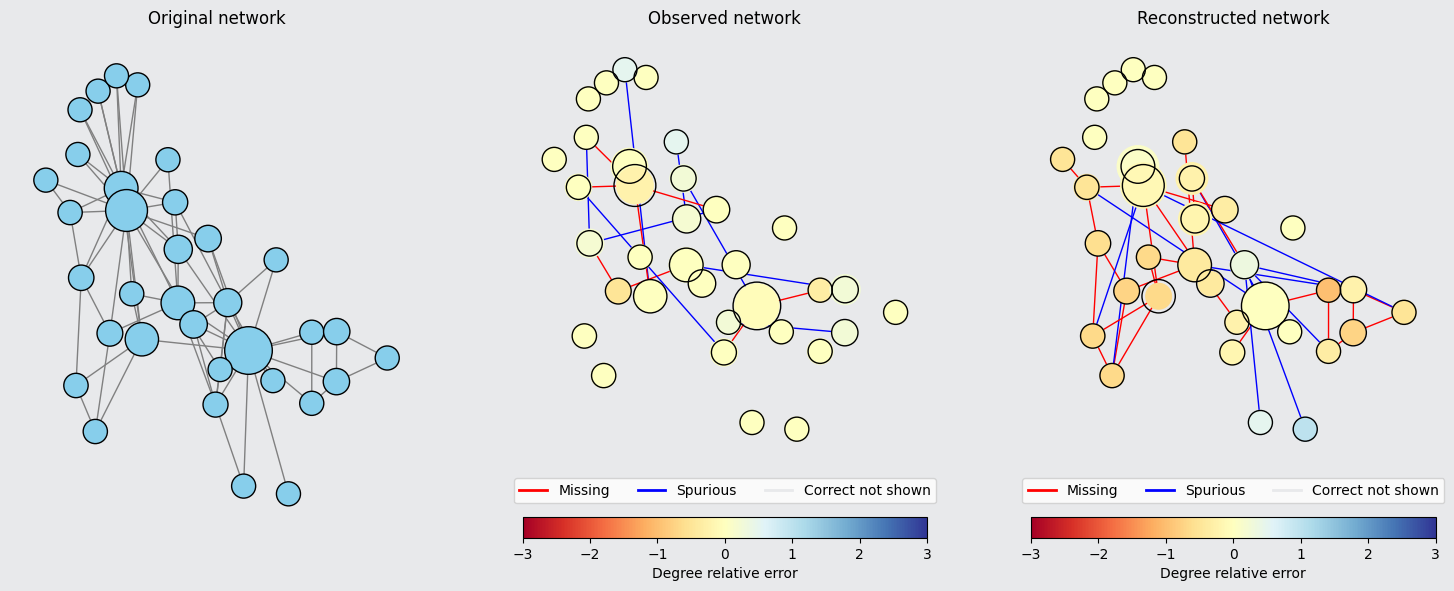

In [16]:
missing, spurious = compareAdjacencyMatrices(A, A_obs)
print("Observed: missing=", len(missing), " ; spurious=", len(spurious))

missing, spurious = compareAdjacencyMatrices(A, A_cur)
print("Reconstructed: missing=", len(missing), " ; spurious=", len(spurious))

fig, ax = plotGraphsComparison(A, A_obs, A_cur)
fig.show()

### Scan reliability

In [44]:
G = nx.karate_club_graph().to_undirected()
A = nx.adjacency_matrix(G).todense()
A = (A > 0).astype(int)
N = A.shape[0]

p_list = [0.1, 0.3, 0.5]
R_N_true = []
R_N_obs = []

for i in tqdm(range(len(p_list))):
  p = p_list[i]

  A_obs = corruptAdjacencyMatrix(A, p=p, mode='both')
  hyper = (5e3, 300, 600, 600) # (n_samples, delay, transient, offset)

  # Observed network reliability
  R_N_observed = getNetworkReliability(A_obs, A_obs, *generatePartitionsSet(A_obs, *hyper))
  R_N_obs.append(R_N_observed)

  # True network reliability
  R_N = getNetworkReliability(A, A_obs, *generatePartitionsSet(A_obs, *hyper))
  R_N_true.append(R_N)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [36:08<00:00, 722.99s/it]


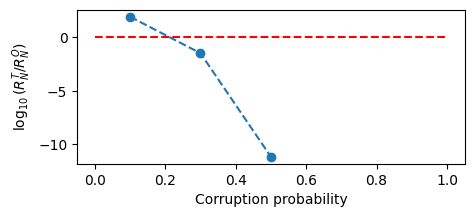

In [45]:
score = np.log10(np.array(R_N_true)/np.array(R_N_obs))

plt.figure(figsize=(5, 2))
plt.plot(p_list, score, 'o--')
plt.hlines(0, 0, 1, color='red', linestyle='--')
plt.xlabel("Corruption probability")
plt.ylabel(r"$\log_{10}(R_N^T / R_N^O)$");

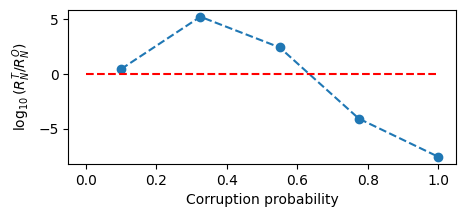

In [19]:
score = np.log10(np.array(R_N_true)/np.array(R_N_obs))

plt.figure(figsize=(5, 2))
plt.plot(p_list, score, 'o--')
plt.hlines(0, 0, 1, color='red', linestyle='--')
plt.xlabel("Corruption probability")
plt.ylabel(r"$\log_{10}(R_N^T / R_N^O)$");

### Link reliability

In [75]:
G = nx.florentine_families_graph().to_undirected()
G = nx.karate_club_graph().to_undirected()

A = nx.adjacency_matrix(G).todense()
A = (A > 0).astype(int)

Missing interaction

In [76]:
p_list = np.linspace(0.1, 0.8, 5)
scores = []
miss_int = []

for p in tqdm(p_list):
    A_obs = corruptAdjacencyMatrix(A, p=p, mode='missing')
    missing, spurious = compareAdjacencyMatrices(A, A_obs)
    miss_int.append(len(missing))
    score = scoreMissing(A, A_obs, n_samples=5e3, delay=50, transient=500, n_cores=-1)
    scores.append(score)
    print("p: ", p, "score: ", score)

  0%|          | 0/5 [00:00<?, ?it/s]

p:  0.1 score:  0.7753868471953579
p:  0.275 score:  0.7458238086864779
p:  0.45000000000000007 score:  0.7289920481409843
p:  0.625 score:  0.6453242805826392
p:  0.8 score:  0.6446532191213042


Text(0.5, 0, 'Number of spurious interactions')

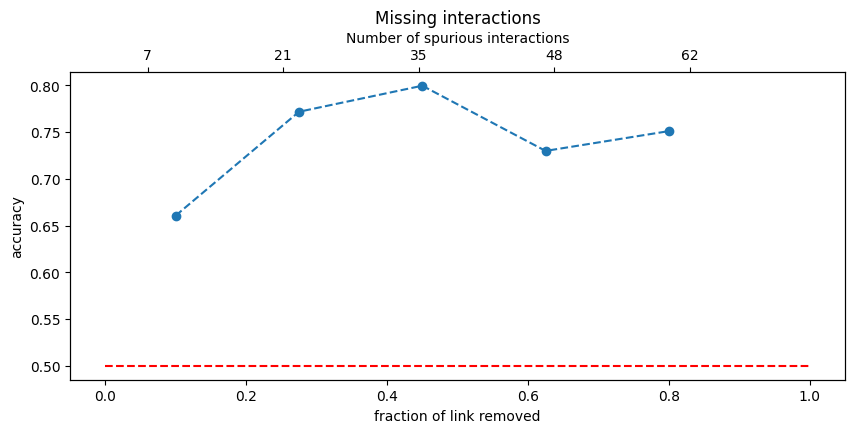

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(p_list, scores, 'o--')
ax.hlines(0.5, 0, 1, color='red', linestyle='--')
ax.set_xlabel("fraction of link removed")
ax.set_ylabel("accuracy")
ax.set_title("Missing interactions")

axsec = ax.twiny()
axsec.set_xticks(p_list)
axsec.set_xticklabels(miss_int)
axsec.set_xlabel("Number of spurious interactions")

Spurious interactions

In [60]:
p_list = np.linspace(0.1, 0.8, 5)
scores = []
spur_int = []

for p in tqdm(p_list):
    A_obs = corruptAdjacencyMatrix(A, p=p, mode='spurious')
    missing, spurious = compareAdjacencyMatrices(A, A_obs)
    spur_int.append(len(spurious))
    score = scoreSpurious(A, A_obs, n_samples=5e3, delay=50, transient=500, n_cores=-1)
    scores.append(score)
    print("p: ", p, "score: ", score)

  0%|          | 0/5 [00:00<?, ?it/s]

p:  0.1 score:  0.6648351648351648
p:  0.275 score:  0.8284493284493285
p:  0.45000000000000007 score:  0.6868131868131868
p:  0.625 score:  0.7569444444444444
p:  0.8 score:  0.7775020678246485


Text(0.5, 0, 'Number of spurious interactions')

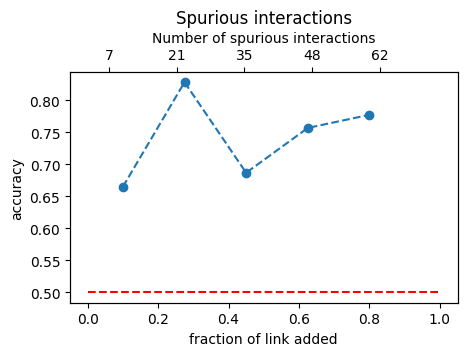

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(p_list, scores, 'o--')
ax.hlines(0.5, 0, 1, color='red', linestyle='--')
ax.set_xlabel("fraction of link added")
ax.set_ylabel("accuracy")
ax.set_title("Spurious interactions")

axsec = ax.twiny()
axsec.set_xticks(p_list)
axsec.set_xticklabels(spur_int)
axsec.set_xlabel("Number of spurious interactions")


### Visual

/home/ubuntu/.local/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


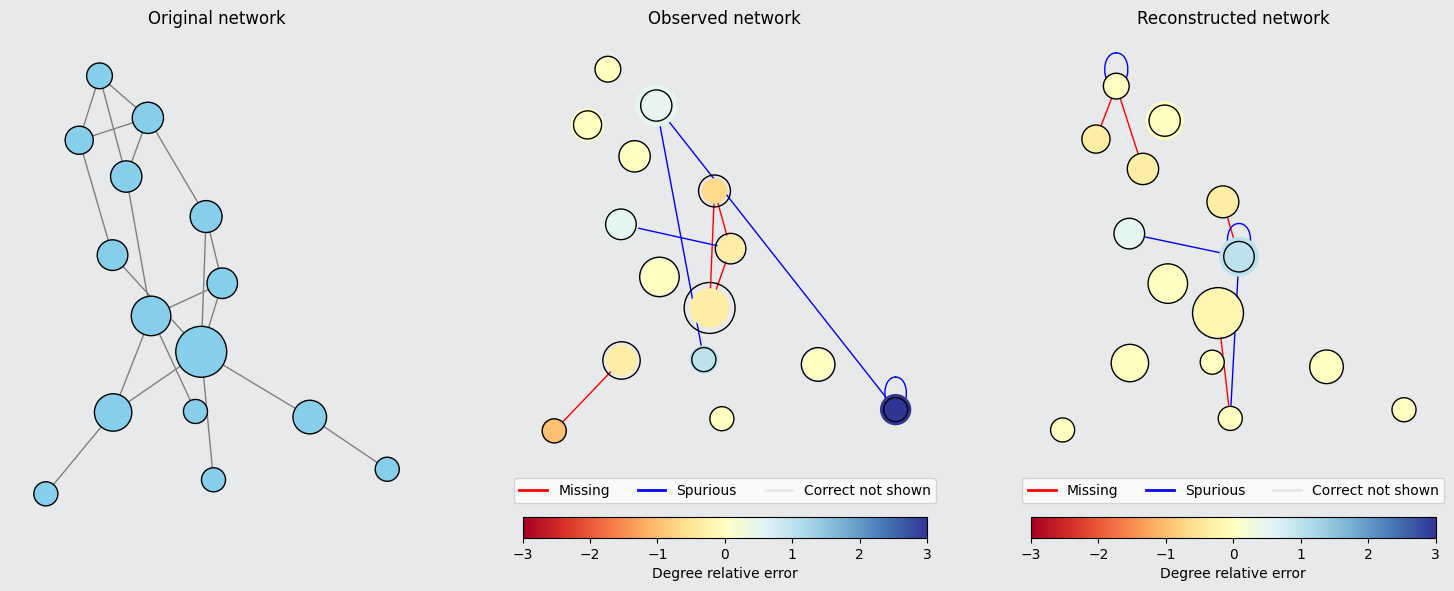

In [6]:
G = nx.florentine_families_graph().to_undirected()
#G = nx.karate_club_graph().to_undirected()
A = nx.adjacency_matrix(G).todense()
del G
A_obs = corruptAdjacencyMatrix(A, p=0.4, mode='both')
A_tilde = corruptAdjacencyMatrix(A, p=0.4, mode='both')

fig, ax = plotGraphsComparison(A, A_obs, A_tilde)
fig.show()

## From logs

### Reliability scan

In [8]:
with open("./logs/scan_karate_club.pkl", "rb") as file:
    results = pickle.load(file)

pprint(results)

{'missing': array([0.59553836, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ]),
 'network': array([ -0.54224408,   3.8672235 ,   0.60504852,  -3.21109664,
        -7.52155527,  -6.18843113,  -4.32611648,  -5.61765342,
        -5.33762121, -17.94804355]),
 'spurious': array([0.77470085, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])}


In [11]:
networks = ["florentine_families", "karate_club", "dolphins"]

p_vec_net = np.arange(0.05, 0.55, 0.05)


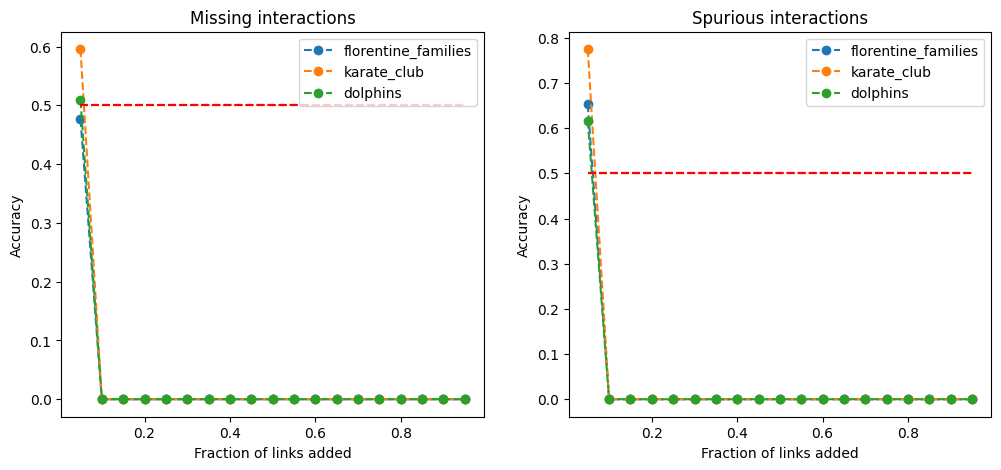

In [16]:
networks = ["florentine_families", "karate_club", "dolphins"]
p_vec_link = np.arange(0.05, 1, 0.05)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, net in enumerate(networks):
    with open(f"./logs/scan_{net}.pkl", "rb") as file:
        results = pickle.load(file)

    ax[0].plot(p_vec_link, results["missing"], 'o--', label=net)
    ax[1].plot(p_vec_link, results["spurious"], 'o--', label=net)

    ax[0].hlines(0.5, p_vec_link[0], p_vec_link[-1], color='red', linestyle='--')
    ax[1].hlines(0.5, p_vec_link[0], p_vec_link[-1], color='red', linestyle='--')
    
    ax[0].set_xlabel("Fraction of links added")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_title("Missing interactions")
    ax[0].legend()
    ax[1].set_xlabel("Fraction of links added")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_title("Spurious interactions")
    ax[1].legend()

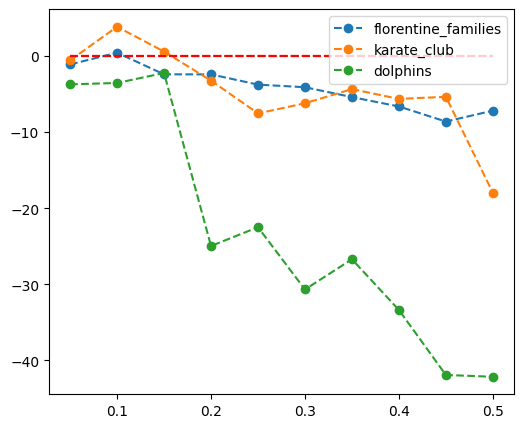

In [21]:
networks = ["florentine_families", "karate_club", "dolphins"]
p_vec_net = np.arange(0.05, 0.55, 0.05)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for i, net in enumerate(networks):
    with open(f"./logs/scan_{net}.pkl", "rb") as file:
        results = pickle.load(file)

    ax.plot(p_vec_net, results["network"], 'o--', label=net)
    ax.hlines(0, p_vec_net[0], p_vec_net[-1], color='red', linestyle='--') 

    ax.legend()
